Potato Disease Classification

In [7]:
# importing dependices
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from IPython.display import HTML

In [8]:
# setting all the constants
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

In [12]:
# tensorflow dataset object importing
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [14]:
class_names= dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [15]:
for image_batch , label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


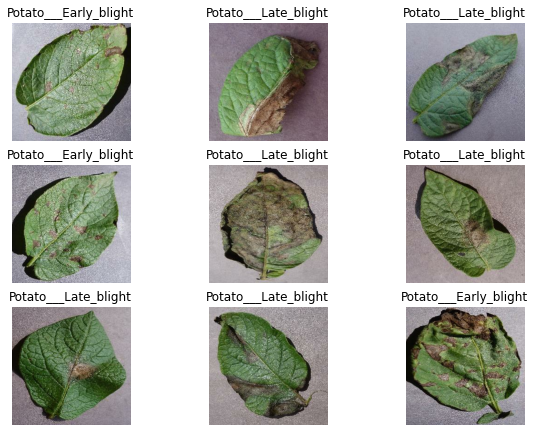

In [23]:
# visual image in dataset
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(4,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

Function to Split Dataset

In [24]:
len(dataset)

68

In [29]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [26]:
train_ds =dataset.take(54)
len(train_ds)

54

In [27]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [28]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [35]:
val_ds =test_ds.take(6)
len(val_ds)

6

In [55]:
test_ds = test_ds.skip(6)
len(test_ds)

0

In [56]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [57]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [58]:
len(train_ds)

54

In [59]:
len(val_ds)

6

In [60]:
len(test_ds)

8

prefetch , shuffle , cache dataset(tf)

In [61]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Resizing and rescaling the images

In [63]:
resize_and_rescale = tf.keras.Sequential ([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [64]:
# Data augumentation (fliping of images)
data_augumentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

# Model Building 

In [66]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augumentation,
    # CNN layer
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    #Flatten the layer
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    #output layer
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [67]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [68]:
model.compile(
optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy']
)

In [69]:
history = model.fit(
   train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
    
)

Epoch 1/50
54/54 [==============================] - 173s 3s/step - loss: 0.9178 - accuracy: 0.4606 - val_loss: 0.8413 - val_accuracy: 0.4740
Epoch 2/50
54/54 [==============================] - 144s 3s/step - loss: 0.6528 - accuracy: 0.6609 - val_loss: 0.5792 - val_accuracy: 0.7031
Epoch 3/50
54/54 [==============================] - 157s 3s/step - loss: 0.4603 - accuracy: 0.7894 - val_loss: 0.4507 - val_accuracy: 0.8125
Epoch 4/50
54/54 [==============================] - 140s 3s/step - loss: 0.3324 - accuracy: 0.8640 - val_loss: 0.2600 - val_accuracy: 0.8906
Epoch 5/50
54/54 [==============================] - 148s 3s/step - loss: 0.3159 - accuracy: 0.8808 - val_loss: 0.2737 - val_accuracy: 0.8854
Epoch 6/50
54/54 [==============================] - 197s 4s/step - loss: 0.2202 - accuracy: 0.9097 - val_loss: 0.3020 - val_accuracy: 0.8958
Epoch 7/50
54/54 [==============================] - 140s 3s/step - loss: 0.1558 - accuracy: 0.9363 - val_loss: 0.1590 - val_accuracy: 0.9479
Epoch 8/50
54

54/54 [==============================] - 107s 2s/step - loss: 0.0243 - accuracy: 0.9890 - val_loss: 0.0731 - val_accuracy: 0.9635
Epoch 42/50
54/54 [==============================] - 158s 3s/step - loss: 0.0112 - accuracy: 0.9948 - val_loss: 0.0156 - val_accuracy: 0.9896
Epoch 43/50
54/54 [==============================] - 193s 4s/step - loss: 0.0071 - accuracy: 0.9977 - val_loss: 0.0157 - val_accuracy: 1.0000
Epoch 44/50
54/54 [==============================] - 157s 3s/step - loss: 0.0383 - accuracy: 0.9907 - val_loss: 0.0465 - val_accuracy: 0.9792
Epoch 45/50
54/54 [==============================] - 166s 3s/step - loss: 0.0325 - accuracy: 0.9890 - val_loss: 0.3046 - val_accuracy: 0.8854
Epoch 46/50
54/54 [==============================] - 168s 3s/step - loss: 0.0093 - accuracy: 0.9965 - val_loss: 0.0258 - val_accuracy: 0.9844
Epoch 47/50
54/54 [==============================] - 127s 2s/step - loss: 0.0050 - accuracy: 0.9977 - val_loss: 0.1091 - val_accuracy: 0.9688
Epoch 48/50
54/54 

In [70]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 8s 339ms/step - loss: 0.1004 - accuracy: 0.9727


In [71]:
 scores

[0.10044240951538086, 0.97265625]

In [72]:
history

In [73]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [74]:
 history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [75]:
 history.history['accuracy']

[0.46064814925193787,
 0.6608796119689941,
 0.7893518805503845,
 0.8640046119689941,
 0.8807870149612427,
 0.9097222089767456,
 0.9363425970077515,
 0.9317129850387573,
 0.9432870149612427,
 0.9508101940155029,
 0.9756944179534912,
 0.9618055820465088,
 0.9785879850387573,
 0.9658564925193787,
 0.984375,
 0.9837962985038757,
 0.9728009104728699,
 0.9756944179534912,
 0.984375,
 0.9878472089767456,
 0.9751157164573669,
 0.9785879850387573,
 0.9953703880310059,
 0.9820601940155029,
 0.9768518805503845,
 0.9866898059844971,
 0.9918981194496155,
 0.9901620149612427,
 0.9849537014961243,
 0.9942129850387573,
 0.9890046119689941,
 0.9866898059844971,
 0.9971064925193787,
 0.9872685074806213,
 0.9947916865348816,
 0.9971064925193787,
 0.9907407164573669,
 0.9924768805503845,
 0.9976851940155029,
 1.0,
 0.9890046119689941,
 0.9947916865348816,
 0.9976851940155029,
 0.9907407164573669,
 0.9890046119689941,
 0.9965277910232544,
 0.9976851940155029,
 0.9907407164573669,
 0.9791666865348816,
 0.99

In [76]:
len( history.history['accuracy'])

50

In [77]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

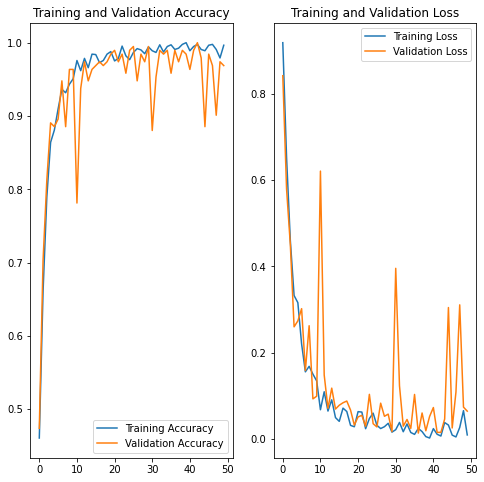

In [78]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [81]:
for image_batch ,label_batch in test_ds.take(1):
    print(image_batch[0].numpy().astype("uint8"))
    

[[[158 156 169]
  [159 157 170]
  [160 158 171]
  ...
  [160 157 168]
  [168 165 176]
  [139 136 147]]

 [[177 175 188]
  [178 176 189]
  [179 177 190]
  ...
  [109 106 117]
  [135 132 143]
  [143 140 151]]

 [[175 173 186]
  [173 171 184]
  [172 170 183]
  ...
  [144 141 152]
  [154 151 162]
  [123 120 131]]

 ...

 [[192 189 196]
  [191 188 195]
  [190 187 194]
  ...
  [181 176 183]
  [111 106 113]
  [151 146 153]]

 [[191 188 195]
  [189 186 193]
  [188 185 192]
  ...
  [117 112 119]
  [136 131 138]
  [168 163 170]]

 [[193 190 197]
  [191 188 195]
  [189 186 193]
  ...
  [121 116 123]
  [140 135 142]
  [148 143 150]]]


first image to predict
first image actual label : Potato___Early_blight
1/1 [==============================] - 0s 312ms/step
[9.9973017e-01 2.6618160e-04 3.6791955e-06]
Potato___Early_blight


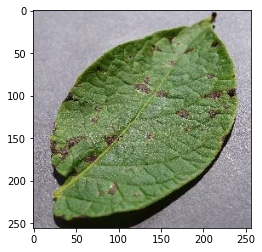

In [90]:
# actual image - 1
for image_batch ,label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype("uint8")
    first_label = label_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("first image actual label :" ,class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print(batch_prediction[0])
    print(class_names[np.argmax(batch_prediction[0])])

function for inference

In [91]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 41ms/step


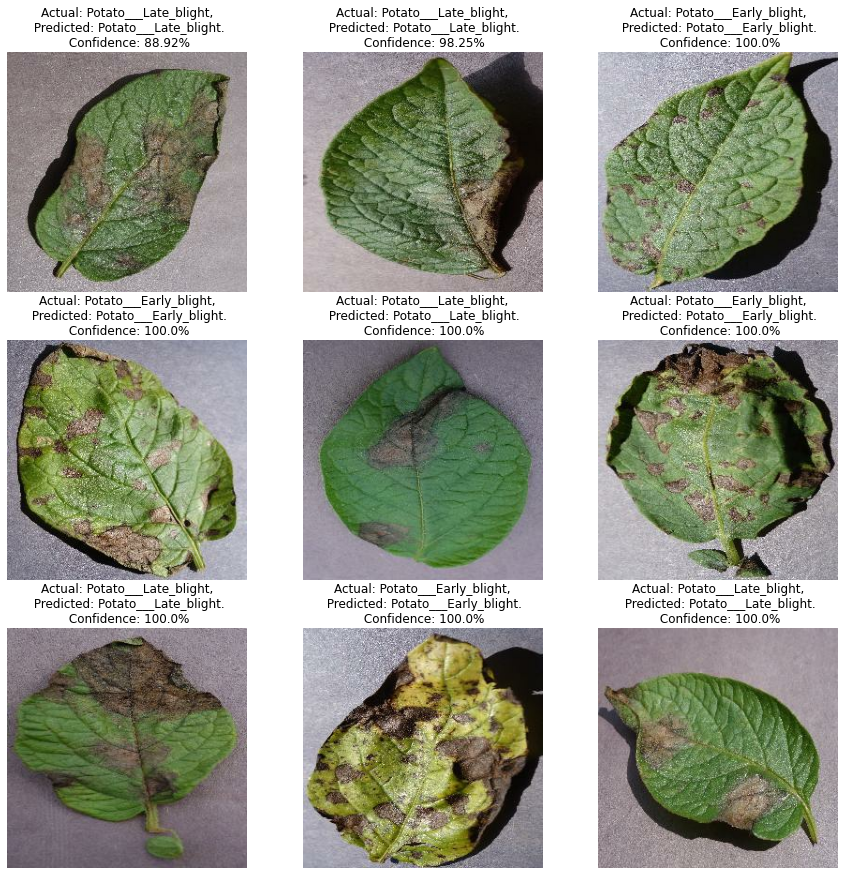

In [92]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# save a model

In [99]:
import os
model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/3\assets


INFO:tensorflow:Assets written to: ../saved_models/3\assets


In [100]:
os.listdir("../saved_models")

['1', '2', '3']

In [95]:
model.save("../potatoes.h5")